In [1]:
import sys
if '..' not in sys.path:
    sys.path.append('..')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.onnx

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

from src.preprocess import append_threshold_channel
from src.cv_cnns import ExtraChannelCNN
from src.train import run_training
from src.data import get_images_annotations, RobotDataset
from src.evaluate import evaluate

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
class AdaptiveExtendingDataset(RobotDataset):
    def transform(self, image):
        image = append_threshold_channel(image)
        return super().transform(image)

In [5]:
dataset = AdaptiveExtendingDataset(get_images_annotations('../dataset'))
train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(val_data, test_size=0.5, random_state=42)

train_data_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_data_loader = DataLoader(val_data, batch_size=32, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=32, shuffle=True)

In [6]:
model = ExtraChannelCNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
NUM_EPOCHS = 20

In [7]:
train_history, val_history = run_training(model, train_data_loader, val_data_loader, optimizer, criterion, NUM_EPOCHS, device)

Running training for 20 epochs.


Epoch 0: 100%|██████████| 190/190 [00:23<00:00,  8.23it/s, loss=0.112] 


Validation loss=0.1810971005690621


Epoch 1: 100%|██████████| 190/190 [00:20<00:00,  9.33it/s, loss=0.0706]


Validation loss=0.14628913510215769


Epoch 2: 100%|██████████| 190/190 [00:14<00:00, 13.23it/s, loss=0.105] 


Validation loss=0.08930603894260418


Epoch 3: 100%|██████████| 190/190 [00:14<00:00, 13.14it/s, loss=0.0477]


Validation loss=0.16503087788975473


Epoch 4: 100%|██████████| 190/190 [00:14<00:00, 13.39it/s, loss=0.0919]


Validation loss=0.07337802834323305


Epoch 5: 100%|██████████| 190/190 [00:14<00:00, 12.97it/s, loss=0.0735]


Validation loss=0.09360111870482891


Epoch 6: 100%|██████████| 190/190 [00:13<00:00, 13.82it/s, loss=0.0653]


Validation loss=0.08126678503482862


Epoch 7: 100%|██████████| 190/190 [00:14<00:00, 12.91it/s, loss=0.0363]


Validation loss=0.14403675098207744


Epoch 8: 100%|██████████| 190/190 [00:12<00:00, 14.69it/s, loss=0.0212] 


Validation loss=0.13165946817447238


Epoch 9: 100%|██████████| 190/190 [00:14<00:00, 13.48it/s, loss=0.00963]


Validation loss=0.1348192366844831


Epoch 10: 100%|██████████| 190/190 [00:13<00:00, 14.48it/s, loss=0.0186] 


Validation loss=0.14701098737958374


Epoch 11: 100%|██████████| 190/190 [00:13<00:00, 13.73it/s, loss=0.0135] 


Validation loss=0.05490048509375472


Epoch 12: 100%|██████████| 190/190 [00:13<00:00, 13.89it/s, loss=0.0211] 


Validation loss=0.11533767735536045


Epoch 13: 100%|██████████| 190/190 [00:13<00:00, 14.49it/s, loss=0.00447]


Validation loss=0.08913281541464456


Epoch 14: 100%|██████████| 190/190 [00:13<00:00, 13.87it/s, loss=0.00838]


Validation loss=0.10068046036566777


Epoch 15: 100%|██████████| 190/190 [00:12<00:00, 14.67it/s, loss=0.0049] 


Validation loss=0.053638795352170816


Epoch 16: 100%|██████████| 190/190 [00:13<00:00, 14.17it/s, loss=0.0121] 


Validation loss=0.10697868876449954


Epoch 17: 100%|██████████| 190/190 [00:13<00:00, 13.59it/s, loss=0.00379]


Validation loss=0.03218382426409965


Epoch 18: 100%|██████████| 190/190 [00:13<00:00, 13.77it/s, loss=0.00189]


Validation loss=0.07378232089936032


Epoch 19: 100%|██████████| 190/190 [00:15<00:00, 12.16it/s, loss=0.00239]


Validation loss=0.05990535398166797


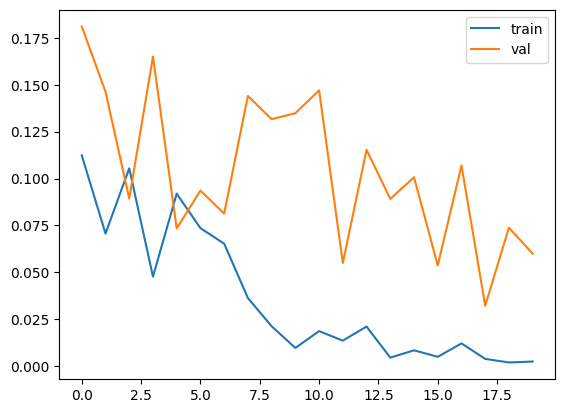

In [12]:
plt.plot(train_history, label='train')
plt.plot(val_history, label='val')
plt.legend()

In [13]:
result = evaluate(model, test_data, device)

print(
    f"Vertical MSE: {result['vertical_mse']:.4f}\n"
    f"Horizontal MSE: {result['horizontal_mse']:.4f}\n"
    f"Total MSE: {result['total_mse']:.4f}\n"
)

Vertical MSE: 0.0358
Horizontal MSE: 0.1861
Total MSE: 0.1110



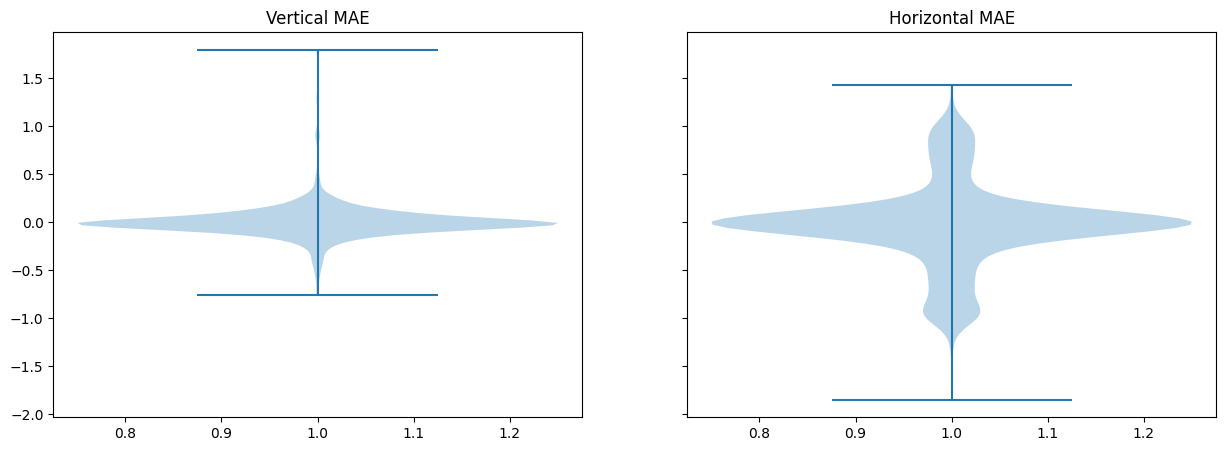

In [14]:
individual_diff = result['individual_prediction_differences']
vertical_diff = individual_diff[:, 0]
horizontal_diff = individual_diff[:, 1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax1.violinplot(vertical_diff)
ax1.set_title('Vertical MAE')
ax2.violinplot(horizontal_diff)
ax2.set_title('Horizontal MAE')

plt.show()

In [11]:
torch.onnx.export(model, torch.randn(1, 4, 224, 224), '../models/extra_channel_cnn.onnx', verbose=True)

graph(%input.1 : Float(1, 4, 224, 224, strides=[200704, 50176, 224, 1], requires_grad=0, device=cpu),
      %features.0.weight : Float(8, 4, 3, 3, strides=[36, 9, 3, 1], requires_grad=1, device=cpu),
      %features.0.bias : Float(8, strides=[1], requires_grad=1, device=cpu),
      %features.2.weight : Float(16, 8, 3, 3, strides=[72, 9, 3, 1], requires_grad=1, device=cpu),
      %features.2.bias : Float(16, strides=[1], requires_grad=1, device=cpu),
      %features.4.weight : Float(32, 16, 3, 3, strides=[144, 9, 3, 1], requires_grad=1, device=cpu),
      %features.4.bias : Float(32, strides=[1], requires_grad=1, device=cpu),
      %classifier.0.weight : Float(256, 3200, strides=[3200, 1], requires_grad=1, device=cpu),
      %classifier.0.bias : Float(256, strides=[1], requires_grad=1, device=cpu),
      %classifier.2.weight : Float(2, 256, strides=[256, 1], requires_grad=1, device=cpu),
      %classifier.2.bias : Float(2, strides=[1], requires_grad=1, device=cpu),
      %30 : Long(2, s